In [1706]:
import numpy as np
import pandas as pd

df = pd.read_csv("laptops.csv")
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


# Preparing the dataset
First, we'll normalize the names of the columns:



In [1707]:
# Preparing the dataset
df.columns = df.columns.str.lower().str.replace(" ", "_")

Next, use only the following columns:

'ram',
'storage',
'screen',
'final_price'

In [1708]:
# selecting the base columns
base = ["ram", "storage", "screen", "final_price"]

df[base].head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


# EDA
Look at the final_price variable. Does it have a long tail?

<Axes: xlabel='final_price', ylabel='Count'>

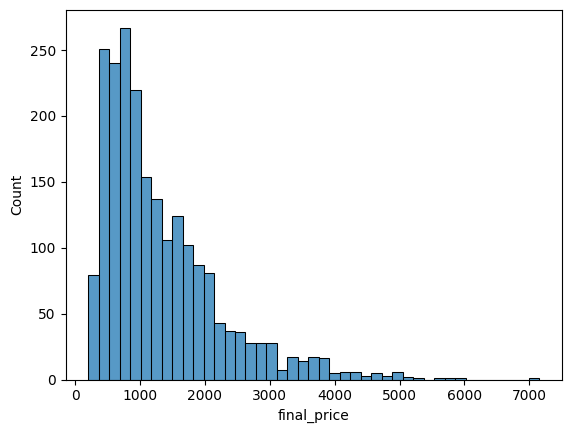

In [1709]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.histplot(
    df[base].final_price,
)

# Question 1
There's one column with missing values. What is it?

'ram'
'storage'
'screen'
'final_price'

In [1710]:
# Q1. which col has missing values
df[base].isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

# Question 2
What's the median (50% percentile) for variable 'ram'?

8
16
24
32

In [1711]:
# q2 what is the median for 'ram'
df[base]["ram"].median()

np.float64(16.0)

# Prepare and split the dataset
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [1712]:
n = len(df[base])

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test
n, n_val + n_test + n_train

(2160, 2160)

In [1713]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df[base].iloc[idx]

# df_shuffled.head()

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

# just resetting the index after shuffling.
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [1714]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [1715]:
# removing the final_price column so as to make sure the training is not biased

del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

# Linear Regression

# Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?
## Options:

- With 0
- With mean
- Both are equally good




In [1716]:
# linear regression algorithm
def train_linear_regression(X, y):
    ones = np.ones(
        X.shape[0]
    )  # adding a column of 1s to the data, to include the W0 term in the model
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [1717]:
def prepare_X(df, fillna_value):
    df = df.copy()
    df = df.fillna(fillna_value)
    X = df.values
    return X

In [1718]:
def rmse(y, y_pred):
    se = (y_pred - y) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [1719]:
# training and finding the RMSE for fillna = 0
print("When fillna = 0")
X_train = prepare_X(df_train, fillna_value=0)
w0, w = train_linear_regression(X_train, y_train)
# finding y_pred for training data
y_pred = w0 + X_train.dot(w)
rmse_train_0 = rmse(y_train, y_pred)
score_train_0 = round(rmse_train_0, 2)
print(f"RMSE between y_train and y_pred: {score_train_0}")

# finding y_pred for validation data
X_val = prepare_X(df_val, fillna_value=0)
y_pred_val = w0 + X_val.dot(w)
rmse_val_0 = rmse(y_val, y_pred_val)
score_val_0 = round(rmse_val_0, 2)
print(f"RMSE between y_val and y_pred: {score_val_0}")

When fillna = 0
RMSE between y_train and y_pred: 602.39
RMSE between y_val and y_pred: 597.36


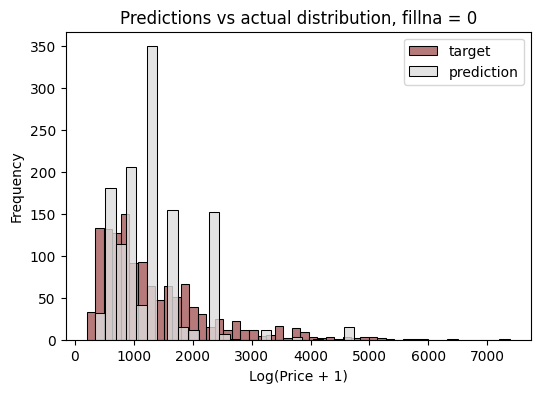

In [1720]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label="target", color="#882222", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="#dddddd", alpha=0.8, bins=40)

plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Log(Price + 1)")
plt.title("Predictions vs actual distribution, fillna = 0")

plt.show()

In [1721]:
# lets train the model with fillna = mean of Q1 answer, only train data
print("When fillna = mean")

mean = df_train["screen"].mean()
X_train = prepare_X(df_train, fillna_value=mean)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
rmse_train_mean = rmse(y_train, y_pred)
score_train_mean = round(rmse_train_mean, 2)
print(f"RMSE between y_train and y_pred: {score_train_mean}")

# finding y_pred for validation data
X_val = prepare_X(df_val, fillna_value=mean)
y_pred = w0 + X_val.dot(w)
rmse_val_mean = rmse(y_val, y_pred)
score_val_mean = round(rmse_val_mean, 2)
print(f"RMSE between y_val and y_pred: {score_val_mean}")

When fillna = mean
RMSE between y_train and y_pred: 602.18
RMSE between y_val and y_pred: 600.27


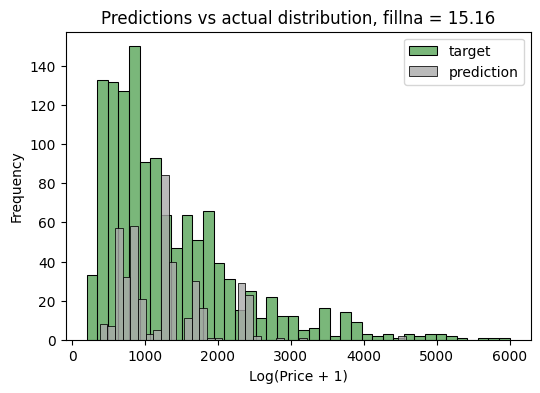

In [1722]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label="target", color="#228822", alpha=0.6, bins=40)
sns.histplot(y_pred, label="prediction", color="#aaaaaa", alpha=0.8, bins=40)

plt.legend()

plt.ylabel("Frequency")
plt.xlabel("Log(Price + 1)")
plt.title(
    f"Predictions vs actual distribution, fillna = {df_train['screen'].mean():.2f}"
)

plt.show()

In [1723]:
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
print(f"RMSE val 0: {rmse_val_0:.2f}")
print(f"RMSE val mean: {rmse_val_mean:.2f}")

RMSE val 0: 597.36
RMSE val mean: 600.27


# Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [1724]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [1725]:
# For this question, fill the NAs with 0.
# Use RMSE to evaluate the model on the validation dataset.
X_train = prepare_X(df_train, fillna_value=0)
print("RMSE on validation dataset:")
reg = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in reg:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w0 + X_val.dot(w)
    score_val = round(rmse(y_val, y_pred), 2)
    print(f"  for r = {r} is {score_val}")

RMSE on validation dataset:
  for r = 0 is 597.36
  for r = 0.01 is 597.36
  for r = 0.1 is 597.35
  for r = 1 is 597.21
  for r = 5 is 597.01
  for r = 10 is 597.06
  for r = 100 is 597.9


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- 29.176
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [1726]:
def linear_regression(seed):
    n = len(df[base])
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_shuffled = df[base].iloc[idx].copy()
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val :].copy()

    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values

    del df_train["final_price"]
    del df_val["final_price"]

    X_train = prepare_X(df_train, fillna_value=0)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)  # fillna = 0
    y_pred = w0 + X_val.dot(w)
    score_val = round(rmse(y_val, y_pred), 2)
    return score_val

In [1727]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seeds:
    scores.append(linear_regression(seed))
scores

[np.float64(565.45),
 np.float64(636.8),
 np.float64(588.96),
 np.float64(597.81),
 np.float64(571.96),
 np.float64(573.24),
 np.float64(647.34),
 np.float64(550.44),
 np.float64(587.33),
 np.float64(576.1)]

In [1728]:
print(f" The standard deviation of all the scores is {round(np.std(scores),3)}")

 The standard deviation of all the scores is 29.176


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- 608.60
- 618.60
- 628.60

In [1729]:
def linear_regression_with_seed(seed):
    n = len(df[base])
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_shuffled = df[base].iloc[idx].copy()
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val :].copy()

    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train["final_price"]
    del df_val["final_price"]
    del df_test["final_price"]

    df_combined_train = pd.concat([df_train, df_val])
    X_combined_train = prepare_X(df_combined_train, fillna_value=0)
    y_combined_train = np.concatenate((y_train , y_val))
    w0, w = train_linear_regression_reg(X_combined_train, y_combined_train, 0.001)

    X_test = prepare_X(df_test, fillna_value=0)
    y_pred = w0 + X_test.dot(w)
    score_val = round(rmse(y_test, y_pred), 2)
    return score_val

In [1730]:
score = linear_regression_with_seed(seed=9)
print(f"The rmse on test dataset is {score}")

The rmse on test dataset is 608.61


In [1733]:
import time

# Get the current local time
local_time = time.localtime()
# Format and print the date, time, and timezone
formatted_time = time.strftime("%Y-%m-%d %H:%M:%S %Z", local_time)
print("Current Date, Time, and Timezone:", formatted_time)

Current Date, Time, and Timezone: 2024-10-09 17:27:20 MDT
